In [ ]:
import ta
import numpy as np
import pandas as pd
import random

import warnings
# Turn off all warnings
warnings.filterwarnings("ignore")

In [9]:
import ccxt
import pandas as pd

# Fetch OHLCV data from Kraken
def fetch_ohlcv_data(start_date):
    exchange = ccxt.kraken()
    symbol = 'BTC/AUD'
    timeframe = '1d'
    since = exchange.parse8601(start_date)
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since, limit=None)
    
    # Convert the data to a Pandas DataFrame and set column names
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'o', 'h', 'l', 'c', 'v'])
    # Convert the timestamp to a human-readable datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    return ohlcv_df

ohlcv_data = fetch_ohlcv_data("2021-01-01T00:00:00Z")

print(ohlcv_data[:3])

   timestamp        o        h        l        c          v
0 2021-05-14  64788.8  66525.8  63557.3  64532.9  14.936609
1 2021-05-15  64381.4  65591.5  60400.0  60635.0  12.292069
2 2021-05-16  60772.4  64094.7  56733.2  60065.5  26.615730


In [25]:
import random

class ProgramTree():
    def __init__(self, dnf):
        self.dnf = dnf

    def __str__(self):
        return f'{self.dnf.__str__()}'

class dnf():
    def __init__(self, conj, dnf):
        self.conj = conj
        self.dnf = dnf

    def __str__(self):
        if self.dnf is not None:
            return f'({self.conj.__str__()} or {self.dnf.__str__()})'
        else:
            return f'{self.conj.__str__()}'

class conj():
    def __init__(self, lit, conj):
        self.lit = lit
        self.conj = conj
    
    def __str__(self):
        if self.conj is not None:
            return f'({self.lit.__str__()} and {self.conj.__str__()})'
        else:
            return f'{self.lit.__str__()}'

class lit():
    def __init__(self, lit, value1, param, value2):
        self.lit = lit
        self.value1 = value1
        self.param = param
        self.value2 = value2
    
    def __str__(self):
        if self.value1 is None:
            return f'(not {self.lit.__str__()})'
        else:
            return f'({self.value1} > {self.param} * {self.value2})'

class Gene:
    def __init__(self):
        self.prog_tree = self.generate_tree()

    def __str__(self):
        return self.prog_tree.__str__()

    def generate_tree(self):
        prog_tree = ProgramTree(self.generate_dnf())

        return prog_tree

    def generate_dnf(self):
        rand_num = random.random()

        if rand_num < 0.5:
            node = dnf(self.generate_conj(), self.generate_dnf())
            return node
        
        node = dnf(self.generate_conj(), None)
        return node

    def generate_conj(self):
        rand_num = random.random()

        if rand_num < 0.5:
            node = conj(self.generate_lit(), self.generate_conj())
            return node
        
        node = conj(self.generate_lit(), None)
        return node

    def generate_lit(self):
        rand_num = random.random()

        if rand_num < 0.5:
            node = lit(self.generate_lit(), None, None, None)
            return node
        
        node = lit(None, self.generate_value(), 'c', self.generate_value())
        return node

    def generate_value(self):
        # Ideally return a function
        return random.choice(['macd', 'rsi', 'sma', 'o(t)'])

gene = Gene()
print(gene)


((o(t) > c * rsi) and (not (not (sma > c * sma))))


In [61]:
"""
Basic Layout with genome functionality
"""
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
import re
# Define the bot's functions

def count_c(gene_expression):
    return len(re.findall(r'\bc\b', gene_expression))

def evaluate_expression(t, P, indicators, weights, expression):

    expression = str(expression)

    ## Stupid way to deal with macd/c, will replace later

    # Temporarily replace 'macd' string
    expression = expression.replace('macd', 'temp_maXd_plaXeholder')

    # Replace 'c' variables directly with their respective weights
    for i, weight in enumerate(weights):
        expression = expression.replace('c', str(weight), 1)

    # Revert 'macd' string back to its original form
    expression = expression.replace('temp_maXd_plaXeholder', 'macd')

    expression = expression.replace('macd', f'indicators.loc[{t}, "macd"]')
    expression = expression.replace('rsi', f'indicators.loc[{t}, "rsi"]')
    expression = expression.replace('sma', f'indicators.loc[{t}, "sma"]')
    expression = expression.replace('o(t)', f'ohlcv_data.loc[{t}, "o"]')
    expression = expression.replace('h(t)', f'ohlcv_data.loc[{t}, "h"]')
    expression = expression.replace('l(t)', f'ohlcv_data.loc[{t}, "l"]')
    expression = expression.replace('c(t)', f'ohlcv_data.loc[{t}, "c"]')
    expression = expression.replace('v(t)', f'ohlcv_data.loc[{t}, "v"]')
    #print("Expression to evaluate:", expression)
    return eval(expression)

def buy_trigger(t, P, indicators, ohlcv_data, buy_gene, buy_weights):
    return evaluate_expression(t, P, indicators, buy_weights, buy_gene)

def sell_trigger(t, P, indicators, ohlcv_data, sell_gene, sell_weights):
    return evaluate_expression(t, P, indicators, sell_weights, sell_gene)

def trading_bot(P, ohlcv_data, buy_gene, sell_gene, buy_weights, sell_weights):

    # Create an RSI indicator with a period of 14
    rsi_period = 20
    rsi_indicator = RSIIndicator(ohlcv_data['c'], window=rsi_period)
    rsi = rsi_indicator.rsi()
    
    # Create an SMA indicator with a period of 20
    sma_period = 20
    sma_indicator = SMAIndicator(ohlcv_data['c'], window=sma_period)
    sma = sma_indicator.sma_indicator()

    # Add the SMA values to the ohlcv_data DataFrame
    ohlcv_data['sma'] = sma

    # Create a MACD indicator with default parameters (12, 26, 9)
    macd_indicator = MACD(ohlcv_data['c'])
    macd = macd_indicator.macd()  # MACD line
    signal = macd_indicator.macd_signal()  # Signal line
    histogram = macd_indicator.macd_diff()  # Histogram (MACD - Signal)

    # Add the MACD values to the indicators DataFrame
    indicators = pd.DataFrame(index=ohlcv_data.index)
    indicators['rsi'] = rsi
    indicators['sma'] = sma
    indicators['macd'] = macd
    indicators['signal'] = signal

    n = len(ohlcv_data)
    positions = []
    bought = False

    fiat_money = 100
    btc_money = 0
    fee = 0.02 # Each buy or sell event costs 2% of current holdings.

    for t in range(1, n):
        close_price = ohlcv_data.loc[t, 'c']      

        if buy_trigger(t, P, indicators, ohlcv_data, buy_gene, buy_weights) and not bought and not sell_trigger(t, P, indicators, ohlcv_data, sell_gene, sell_weights):
            positions.append(('buy', t))
            btc_money = (fiat_money / close_price) * (1 - fee)
            fiat_money = 0
            bought = True
        elif sell_trigger(t, P, indicators, ohlcv_data, sell_gene, sell_weights) and bought and not buy_trigger(t, P, indicators, ohlcv_data, buy_gene, buy_weights):
            positions.append(('sell', t))
            fiat_money = (btc_money * close_price) * (1 - fee)
            btc_money = 0
            bought = False

    if bought:
        positions.append(('sell', n - 1))

    return positions, fiat_money, btc_money

P = [30, 70]  # Define the set of parameters for the bot (buy RSI threshold, sell RSI threshold)
buy_gene = Gene()
sell_gene = Gene()

print(buy_gene)
print(sell_gene)

buy_weights = [0.5, 0.6, 0.7, 0.8] * count_c(str(buy_gene))  # Example weights for buy_gene
sell_weights = [0.9, 1.0, 1.1, 1.2] * count_c(str(sell_gene))  # Example weights for sell_gene
positions, fiat_money, btc_money = trading_bot(P, ohlcv_data, buy_gene, sell_gene, buy_weights, sell_weights)
print(positions)
print(fiat_money, btc_money)

((macd > c * sma) and (not (not (rsi > c * o(t)))))
((not (rsi > c * o(t))) or ((o(t) > c * macd) or (((macd > c * rsi) and ((not (rsi > c * sma)) and ((o(t) > c * o(t)) and (not (not (sma > c * sma)))))) or ((not (o(t) > c * rsi)) and ((not (not (not (not (not (rsi > c * o(t))))))) and ((not (not (macd > c * rsi))) and ((o(t) > c * macd) and (rsi > c * rsi))))))))
[]
100 0


In [36]:
import copy
import numpy as np
best_genome = None

class Genome:
    def __init__(self, fitness, genes):
        self.fitness = fitness
        self.genes = genes



class TrainGenomes():
	def __init__(self, population_size, generations, num_weights, num_b, ohlcv_data):
		self.population_size = population_size
		self.generations = generations
		self.num_weights = num_weights
		self.num_b = num_b
		self.ohlcv_data = ohlcv_data

	def train(self):
		global best_genome
		# Initialize the population

		no_improvement = 0
		mutation_rate = 0.05

		population = self.initialize_population(self.population_size, self.num_weights)
		# Evaluate the population
		for i in range(self.generations):
			population = self.evaluate_population(population)
			# Sort the population by fitness
			population.sort(key=lambda x: x.fitness, reverse=True)
			# # Keep track of the best genome
			#self.save_population(population,f"pre_genomes.csv")
			print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")


			if i > 0 and population[0].fitness == best_genome.fitness:
				no_improvement += 1
			else:
				no_improvement = 0
			# Update the mutation rate
			if no_improvement > 5:
				mutation_rate *= 1.1
			else:
				mutation_rate = 0.05

			best_genome = population[0]
			# Seperate elite from population
			# do tournament selection for next generation
			population = self.tournament_selection(population, 0.05, 2, mutation_rate)
			# # Add the elite to the population
			# population.extend(elite)
			population.sort(key=lambda x: x.fitness, reverse=True)
			#self.save_population(population,f"post_genomes.csv")
	    
	def save_population(self,population,name):
		#save list of population classes as csv
		lst = [x.__dict__ for x in population]
		pd.DataFrame(lst).to_csv(f"{name}.csv")


	def initialize_population(self, population_size, num_weights):
		population = []
		for i in range(population_size):
			genes = np.random.uniform(0, 1, num_weights)
			population.append(Genome(0, genes))
		return population

	
	def evaluate_population(self, population):
		for genome in population:
			genome.fitness = self.fitness(genome)

		return population
	
	def fitness(self, genome):

		P = [30, 70]  # Define the set of parameters for the bot (buy RSI threshold, sell RSI threshold)

		buy_weights = genome.genes[:self.num_b]
		sell_weights = genome.genes[self.num_b:]
		positions, fiat_money, btc_money = trading_bot(P, ohlcv_data, buy_gene, sell_gene, buy_weights, sell_weights)

		return fiat_money + (btc_money * ohlcv_data.iloc[-1]['c'])
	
	
	def tournament_selection(self, population, elitism, tournament_size, mutation_rate):
        # Select elite
		elite = population[:int(elitism * len(population))]
        # Initialize an empty list for the parents
		parents = []
		for _ in range(len(population) - len(elite)):
            # Randomly select tournament_size genomes
			tournament = np.random.choice(population, size=tournament_size)
            # Select the best genome
			winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
            # Apply mutation to winner.genes
			for i in range(winner.genes.size):
				mutation = np.random.uniform(-mutation_rate, mutation_rate)
				winner.genes[i] = max(0, winner.genes[i] + mutation)
            # Add the winner to the parents list
			parents.append(winner)

        # Add the elite to the parents list
		parents.extend(elite)
		return parents


In [62]:
import random

buy_gene = Gene()
sell_gene = Gene()

print(buy_gene)
print(sell_gene)

num_weights=count_c(str(buy_gene))+count_c(str(sell_gene))
num_b = count_c(str(buy_gene))
num_s = count_c(str(sell_gene))

train_genomes = TrainGenomes(population_size=100, generations=3, num_weights=num_weights, num_b=num_b, ohlcv_data=ohlcv_data)









train_genomes.train()
print("Best genome:", best_genome.genes)
print("Best genome fitness:", best_genome.fitness)


(macd > c * macd)
((not (o(t) > c * o(t))) and ((rsi > c * rsi) and ((not (rsi > c * macd)) and (not (sma > c * rsi)))))
Generation 0 best genome fitness: 82.575969012083, average fitness: 82.57596901208296
Generation 1 best genome fitness: 82.575969012083, average fitness: 82.57596901208296
Generation 2 best genome fitness: 96.55340733086469, average fitness: 82.85551777845862
Best genome: [1.02886634 0.29899042 0.80126395 0.84208269 0.46089368]
Best genome fitness: 96.55340733086469


96.55340733086469


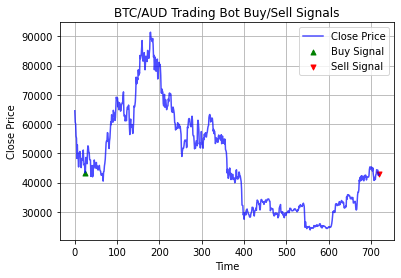

In [48]:
positions, fiat_money, btc_money = trading_bot(P, ohlcv_data, buy_gene, sell_gene, best_genome.genes[:num_b], best_genome.genes[num_b:])
print(fiat_money + (btc_money * ohlcv_data.iloc[-1]['c']))
import matplotlib.pyplot as plt

# Extract the timestamps, close prices, and buy/sell signals
timestamps = ohlcv_data.index
close_prices = ohlcv_data['c']
buy_signals = [t for action, t in positions if action == 'buy']
sell_signals = [t for action, t in positions if action == 'sell']

# Plot the price data
plt.plot(timestamps, close_prices, label='Close Price', color='blue', alpha=0.7)

# Plot the buy signals
plt.scatter([timestamps[t] for t in buy_signals],
            [close_prices[t] for t in buy_signals],
            color='g', s=25, marker="^", label='Buy Signal')

# Plot the sell signals
plt.scatter([timestamps[t] for t in sell_signals],
            [close_prices[t] for t in sell_signals],
            color='r', s=25, marker="v", label='Sell Signal')

# Customize the plot appearance

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('BTC/AUD Trading Bot Buy/Sell Signals')
plt.legend()
plt.grid()

# Show the plot
plt.show()